## Set-up

In [1]:
import pandas as pd
from sklearn.decomposition import NMF
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
import numpy as np
from tqdm.notebook import trange

sns.set_theme()
colors = sns.color_palette("deep")

from utils import geometric_median, geometric_medoid
from NMF_iter import normalize_curves, functional_norm
from itertools import permutations

# HOTFIX Parse IMCEI
import locale
locale.setlocale(locale.LC_ALL, 'it_IT')

'it_IT'

In [2]:
def plot_components(H, ax=None, figsize=(10, 6), title='Components found by the NMF', component_names=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    else:
        fig = ax.get_figure()

    n_components = H.shape[0]
    abscissa = np.linspace(0, 24, H.shape[1])
    for k in range(n_components):
        if component_names is not None:
            label = component_names[k]
        else:
            label = f'Component {k + 1}'
        ax.plot(abscissa, H[k, :], marker='o', linestyle='-', label=label)

    ax.set_xlabel('Hour')
    ax.set_ylabel('Load (MW)')
    ax.set_title(title)
    ax.legend()
    
    return fig, ax

In [3]:
def initialize_W(X, n_components):
    W = pd.DataFrame(np.random.rand(len(X), n_components), index=X.index, columns=[f"Component {k+1}" for k in range(n_components)])
    W = W.div(W.sum(axis=1), axis=0)
    return W

In [4]:
def align_components(H_results, W_results, ref_idx=0):
    # Align the components
    n_comp, n_eval_points, n_runs = H_results.shape
    ref_H = H_results[..., ref_idx]

    for n in range(1, n_runs):

        best_permutation = list(range(n_comp))
        eval_points = np.arange(0, n_eval_points, int(n_eval_points / 24))
        best_alignment = np.linalg.norm(ref_H - H_results[..., n][range(n_comp), :], 'fro')

        for permutation in list(permutations(range(n_comp))):
            alignment = np.linalg.norm(ref_H - H_results[..., n][list(permutation)[:n_comp], :], 'fro')

            if alignment < best_alignment:
                best_alignment = alignment
                best_permutation = list(permutation)

        H_results[..., n] = H_results[..., n][best_permutation, :]
        W_results[..., n] = W_results[..., n][:, best_permutation]

In [5]:
n_components = 3 # Number of components for the matrix factorization
n_runs = 10000
smoothed = False

colormap = ListedColormap([colors[k] for k in range(n_components)])

region_order = [
    'North',
    'Centre.North',
    'Sardinia',
    'Centre.South',
    'South',
    'Calabria',
    'Sicily'
]

# Process data

## Data matrix $X$

In [6]:
if smoothed:
    infile = 'data/daily_curves_pos_smoothed_13b_15min.csv'
else:
    infile = 'data/2_processed/daily_curves.csv'
input_df = pd.read_csv(infile, index_col=0)
print(len(input_df))
input_df.head(3)

11686


,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
Calabria_2021-01-01_Holiday,620.000,553.527,505.844,458.280,416.869,403.580,418.381,430.841,447.541,535.429,...,572.905,599.759,741.648,732.026,759.323,783.827,747.433,700.825,658.620,552.943
Calabria_2021-01-02_Saturday,552.943,514.861,462.221,448.924,457.576,462.207,492.594,526.408,579.682,648.228,...,648.877,658.723,745.817,773.431,828.180,831.509,758.732,669.630,596.548,518.853
Calabria_2021-01-03_Holiday,518.853,457.879,432.200,419.060,393.992,438.706,462.433,488.501,532.412,641.866,...,678.540,666.579,730.333,764.207,819.056,825.176,754.773,706.062,629.708,540.431


In [7]:
unit_info = input_df.index.str.extract(r'^(?P<region>[\w.]+)_(?P<year>\d{4})-(?P<month>\d{2})-\d{2}_(?P<daytype>[\w ]+)$').set_index(input_df.index)
df = pd.concat([input_df, unit_info], axis=1)
# df = df[df.month.isin(months)]
# df = df[(df.month == '10')&(df.daytype=='Working day')]
print(len(df))
df.head(3)

11686


,0,1,2,3,4,5,6,7,8,9,...,19,20,21,22,23,24,region,year,month,daytype
Calabria_2021-01-01_Holiday,620.000,553.527,505.844,458.280,416.869,403.580,418.381,430.841,447.541,535.429,...,759.323,783.827,747.433,700.825,658.620,552.943,Calabria,2021,01,Holiday
Calabria_2021-01-02_Saturday,552.943,514.861,462.221,448.924,457.576,462.207,492.594,526.408,579.682,648.228,...,828.180,831.509,758.732,669.630,596.548,518.853,Calabria,2021,01,Saturday
Calabria_2021-01-03_Holiday,518.853,457.879,432.200,419.060,393.992,438.706,462.433,488.501,532.412,641.866,...,819.056,825.176,754.773,706.062,629.708,540.431,Calabria,2021,01,Holiday


In [8]:
X = df.drop(unit_info.columns, axis=1)
X = normalize_curves(X)
X.head()

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
Calabria_2021-01-01_Holiday,0.043820,0.039122,0.035752,0.032390,0.029463,0.028524,0.029570,0.030451,0.031631,0.037843,...,0.040491,0.042389,0.052418,0.051738,0.053667,0.055399,0.052827,0.049532,0.046549,0.039081
Calabria_2021-01-02_Saturday,0.036819,0.034283,0.030778,0.029892,0.030469,0.030777,0.032800,0.035052,0.038599,0.043163,...,0.043207,0.043862,0.049662,0.051500,0.055146,0.055368,0.050522,0.044589,0.039722,0.034549
Calabria_2021-01-03_Holiday,0.034625,0.030556,0.028842,0.027966,0.026293,0.029277,0.030860,0.032600,0.035530,0.042834,...,0.045282,0.044483,0.048738,0.050998,0.054659,0.055067,0.050369,0.047118,0.042023,0.036065
Calabria_2021-01-04_Working day,0.030835,0.025677,0.024763,0.024702,0.024831,0.026079,0.029497,0.035669,0.039430,0.050540,...,0.048232,0.045538,0.049652,0.050852,0.055957,0.052859,0.048213,0.043190,0.039265,0.034334
Calabria_2021-01-05_Working day,0.034956,0.031889,0.030023,0.029715,0.028913,0.030107,0.033811,0.039218,0.043283,0.053841,...,0.046168,0.044271,0.047506,0.051417,0.051633,0.050358,0.046345,0.040047,0.035615,0.030337


## NMF

In [9]:
p = len(X.columns)

In [10]:
# Load the arrays from the .npz file
if smoothed:
    path = f'data/3_output/nmf_results/batch/{n_components}comp_smoothed_{n_runs}runs.npz'
else:  
    path = f'data/3_output/nmf_results/batch/{n_components}comp_{n_runs}runs.npz'
data = np.load(path)
print('Loaded ', path)

Loaded  data/3_output/nmf_results/batch/3comp_10000runs.npz


In [11]:
# Access the arrays
H_results = data['H_results']
W_results = data['W_results']
iterations = data['iterations']
errors = data['errors']

In [12]:
# Remove results for which we have less than 100 iterations (they correspond to a local minima where all profile are the same)
H_results = H_results[..., iterations > 100]
W_results = W_results[..., iterations > 100]
errors = errors[iterations > 100]
iterations = iterations[iterations > 100]
print('{} results clean'.format(W_results.shape[2]))

3475 results clean


In [13]:
# Align solutions to have comp x of solution i matching comp x of solution j
align_components(H_results, W_results, ref_idx=478)

In [14]:
n_clean_runs = W_results.shape[2]
abscissa = [float(x) for x in X.columns]

## Quick data check

Check-plots on the solutions found

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))

for k in range(n_components):
    for i in range(n_clean_runs):
        line, = ax.plot(abscissa, H_results[k, :, i], linewidth=0.1, color=colors[k])
    label = f'Component {k + 1}'
    ax.plot(abscissa, geometric_median(H_results[k, ...].T), linewidth=2, color=colors[k], label=label)
    ax.plot(abscissa, geometric_medoid(H_results[k, ...].T), linewidth=3, linestyle='dotted', color=colors[k])
ax.set_title(f"All components found by the NMF with k={n_components} on the {(1-smoothed)*'original' + smoothed*'smoothed'} data")
ax.legend()
plt.tight_layout()

Let's plot separately per component

In [ ]:
k = 0
fig, ax = plt.subplots(figsize=(10, 5))
for i in range(n_clean_runs):
    line, = ax.plot(abscissa, H_results[k, :, i], linewidth=0.1, color=colors[k])
ax.plot(abscissa, geometric_median(H_results[k, ...].T), linewidth=2, color='darkred')
ax.plot(abscissa, geometric_medoid(H_results[k, ...].T), linewidth=3, linestyle='dotted', color='darkred')
ax.set_title(f"Component {k + 1} found by the NMF with k={n_components} on the {(1-smoothed)*'original' + smoothed*'smoothed'} data")
plt.tight_layout()

In [ ]:
pd.Series(errors).hist()

# Selection of the optimal solution

## Based on modelling constraints

### Cyclic profiles

We want to find solutions for which
$$\text{discontinuity}(H) = \sum_{k=1}^K(H_k(p) - H_k(1))^2$$

In [15]:
H_discontinuity = ((H_results[:, 0, :] - H_results[:, p-1, :])**2).sum(axis=0)

In [ ]:
pd.Series(H_discontinuity).hist()

### Total distance of concentration vectors to simplex

The distance to the simplex of one observation $x$ to the simplex $\mathcal{S}(n)$ is the following
$$\text{dist}(x, \mathcal{S}(n)) = \inf_{\substack{y \in \mathcal{S}(n)}} d(x, y)$$

The point $y$ minimizing the distance is:
$$y = \frac{x}{||x||_1}$$

Here we will compute the sum of the distances to the simplex for all vector of concentrations of the matrix $W$

In [17]:
W_proj_simplex = W_results / W_results.sum(axis=1)[:, np.newaxis, :]
W_dist_simplex = np.sqrt(((W_results - W_proj_simplex)**2).sum(axis=1))
W_sum_dist_simplex = W_dist_simplex.sum(axis=0)

In [ ]:
pd.Series(W_sum_dist_simplex).hist()

### Total distance of the components to the p-dimensional simplex

Similarly, the unit l1 norm constraint on the components, having necessarily positive coordinates, result in the components having to lie on the unit 1-sphere

In [19]:
H_proj_unit = np.empty_like(H_results)
for n in range(H_results.shape[2]):
    H_proj_unit[..., n] = normalize_curves(H_results[..., n])
H_dist_unit = np.sqrt(((H_results - H_proj_unit)**2).sum(axis=1))
H_sum_dist_unit = H_dist_unit.sum(axis=0)

In [ ]:
pd.Series(H_sum_dist_unit).hist()

### Pair plots

In [ ]:
import plotly.graph_objects as go

# Create a scatter plot
fig = go.Figure(
    data=go.Scatter(
        x=W_sum_dist_simplex,
        y=H_discontinuity,
        mode='markers',
        hoverinfo='text',
        text=[f'Index: {i}' for i in range(len(W_sum_dist_simplex))]
        )
    )

# Add labels and title
fig.update_layout(
    xaxis_title='Sum of distance to the simplex',
    yaxis_title='Discontinuity of the profiles',
    title='Compliance of solutions with physics of the system',
    height=800,
    width=1000
)

# # Show the plot
# fig.show()

In [ ]:
import plotly.graph_objects as go

# Create a scatter plot
fig = go.Figure(
    data=go.Scatter(
        x=W_sum_dist_simplex,
        y=H_sum_dist_unit,
        mode='markers',
        hoverinfo='text',
        text=[f'Index: {i}' for i in range(len(W_sum_dist_simplex))]
        )
    )

# Add labels and title
fig.update_layout(
    xaxis_title='Sum of distance to the simplex for W',
    yaxis_title='Sum of distance to the unit sphere for H',
    title='Compliance of solutions with physics of the system',
    height=800,
    width=1000
)

# # Show the plot
# fig.show()

In [ ]:
import plotly.graph_objects as go

# Create a scatter plot
fig = go.Figure(
    data=go.Scatter(
        x=W_sum_dist_simplex,
        y=errors / int(X.shape[1] / 24),
        mode='markers',
        hoverinfo='text',
        text=[f'Index: {i}' for i in range(len(W_sum_dist_simplex))]
        )
    )

# Add labels and title
fig.update_layout(
    xaxis_title='Sum of distance to the simplex for W',
    yaxis_title='Reconstruction error',
    title='Compliance of solutions with physics of the system and approximation quality',
    height=800,
    width=1000
)

# # Show the plot
# fig.show()

## Based on compliance with consumption data

In [24]:
cons_df = pd.read_excel('data/1_input/consumption/consumption_chart.xlsx')

# We put agricoltura sector in the industrial one
cons_df['Settore corretto'] = cons_df['Settore corretto'].replace('Agricoltura', 'Industria')
region_cons_df = pd.pivot_table(cons_df, values='Sum of Consumo corretto', index=['Zone', 'year'], columns='Settore corretto', aggfunc='sum')
region_cons_df.columns.name = None
region_cons_df = region_cons_df[['Servizi', 'Industria', 'Domestico']]

# Align with the consumption computed from the load data
uncorrected_total = region_cons_df[['Servizi', 'Industria', 'Domestico']].sum(axis=1).values
corrected_total = df.groupby(['region', 'year'])[[str(i) for i in range(24)]].sum().sum(axis=1).values / 1000
region_cons_df = region_cons_df.mul(corrected_total / uncorrected_total, axis=0)
region_cons_df

Servizi     Industria     Domestico
Zone         year                                          
Calabria     2021   2541.975273   1295.849924   2782.654704
             2022   2627.629999   1261.093017   2669.952205
Centre-North 2018  11987.996787  15043.496012   7282.482225
             2019  11112.598565  15674.507679   7305.126886
             2020   8759.424234  15207.980401   7213.521690
             2021   8161.204160  13327.867574   6368.502639
             2022   8616.624929  13029.261317   6200.665367
Centre-South 2018  19976.347063  12700.311797  14017.064009
             2019  19772.016954  13631.094948  14293.373072
             2020  17218.840831  13536.204996  14545.866128
             2021  19770.418976  17714.659380  15937.164866
             2022  20853.271645  17615.761924  15786.516089
North        2018  58528.554523  90950.405399  32864.307851
             2019  55134.074728  92081.219888  33128.302437
             2020  46878.115290  89980.492491  33245.407821
             2021  48805.070370  97400.694651  32645.256512
             2022  51137.111065  93701.550786  31785.625981
Sardinia     2018   2424.073830   4322.100539   2331.730579
             2019   2353.652817   4324.379498   2381.449541
             2020   2063.516268   4189.862650   2417.383339
             2021   2233.019413   4334.125821   2514.842590
             2022   2376.863962   4084.432676   2502.298164
Sicily       2018   6104.767363   6867.185541   6087.933269
             2019   6206.994939   6885.933932   6084.484759
             2020   5236.319687   6819.141203   6367.573081
             2021   5580.914116   6769.004688   6683.575983
             2022   5652.472948   7083.061800   6358.932057
South        2018   9333.856785  12751.279212   8096.858238
             2019   8778.420455  12722.726417   7917.468300
             2020   7620.267697  12199.992898   8039.805381
             2021   5938.130393  11560.614748   5917.978173
             2022   5921.490366  10705.893111   5453.532560

In [25]:
X_unnorm = df.drop(unit_info.columns, axis=1)
h = 24 / (X_unnorm.shape[1]-1)
norm_X = X_unnorm.apply(lambda row: functional_norm(row, h), axis=1, raw=True)

cons = np.zeros((len(region_cons_df), n_components, n_clean_runs))
dist_to_cons = np.zeros(n_clean_runs)

for i in trange(W_results.shape[-1]):

    W = W_results[..., i]
    H = H_results[..., i]

    day_cons = pd.DataFrame(W, index=norm_X.index).mul(norm_X, axis=0)
    day_cons['region'] = unit_info['region']
    day_cons['year'] = unit_info['year']
    best_year_cons = day_cons.groupby(['region', 'year']).sum() / 1000
    min_dist = abs(best_year_cons - region_cons_df.values).values.sum()
    best_permutation = list(range(n_components))

    for permutation in list(permutations(range(n_components))):
        day_cons = pd.DataFrame(W[:, list(permutation)], index=norm_X.index).mul(norm_X, axis=0)
        day_cons['region'] = unit_info['region']
        day_cons['year'] = unit_info['year']
        year_cons = day_cons.groupby(['region', 'year']).sum() / 1000
        dist = abs(year_cons - region_cons_df.values).values.sum()
        if dist < min_dist:
            min_dist = dist
            best_permutation = list(permutation)
            best_year_cons = year_cons

    W_results[..., i] = W[:, best_permutation]
    H_results[..., i] = H[best_permutation, :]
    cons[..., i] = best_year_cons.values
    dist_to_cons[i] = min_dist


  0%|          | 0/3475 [00:00<?, ?it/s]

<Axes: >

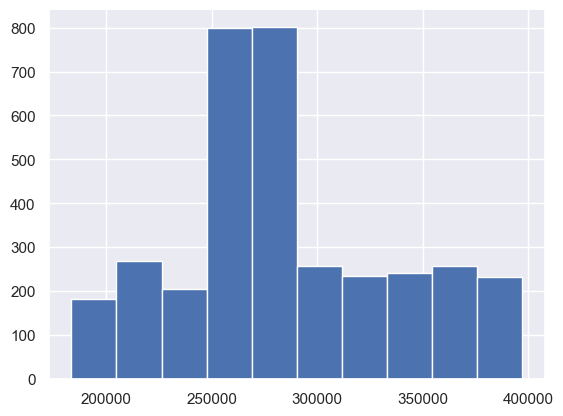

In [26]:
pd.Series(dist_to_cons).hist()

### Pair plots

In [ ]:
# Create a scatter plot
fig = go.Figure(
    data=go.Scatter(
        x=W_sum_dist_simplex,
        y=dist_to_cons,
        mode='markers',
        hoverinfo='text',
        text=[f'Index: {i}' for i in range(len(W_sum_dist_simplex))]
        )
    )

# Add labels and title
fig.update_layout(
    xaxis_title='Sum of distance to the simplex for W',
    yaxis_title='Distance to consumption data',
    title='Compliance of solutions with physics of the system and approximation quality',
    height=800,
    width=1000
)

# # Show the plot
# fig.show()

In [ ]:
# Create a scatter plot
fig = go.Figure(
    data=go.Scatter(
        x=H_sum_dist_unit,
        y=dist_to_cons,
        mode='markers',
        hoverinfo='text',
        text=[f'Index: {i}' for i in range(len(W_sum_dist_simplex))]
        )
    )

# Add labels and title
fig.update_layout(
    xaxis_title='Sum of distance to the unit for H',
    yaxis_title='Distance to consumption data',
    title='Compliance of solutions with physics of the system',
    height=800,
    width=1000
)

# # Show the plot
# fig.show()

## Based on compliance with indexes

### Read indexes

In [65]:
imser = pd.read_excel('data/1_input/indicators/IMSER.xlsx')
imser = imser[imser.Mese.dt.year != 2023].set_index('Mese').rename({'IMSER (GWh)': 'IMSER'}, axis=1) # We don't have data for this year

imcei = pd.read_excel('data/1_input/indicators/IMCEI_mensile.xlsx')
imcei['Mese'] = pd.to_datetime(imcei['Anno'].astype(str) + '-' + imcei['Mese'], format='%Y-%b')
imcei = imcei.set_index('Mese').drop('Anno', axis=1).rename({'IMCEI Mensile': 'IMCEI'}, axis=1)

domestic = pd.read_excel('data/1_input/indicators/Domestico 2020 e 2021.xlsx', skiprows=12, usecols=range(3))
domestic = domestic.set_index('Mese').drop('Domestico kWh', axis=1)

indics = imcei.copy()
indics['IMSER'] = imser['IMSER']
indics['EniDom'] = domestic['Domestico GWh']
indics

,IMCEI,IMSER,EniDom
Mese,,,
2018-01-01,101.876892,NaN,NaN
2018-02-01,104.070890,NaN,NaN
2018-03-01,112.023582,NaN,NaN
2018-04-01,102.915390,NaN,NaN
2018-05-01,113.072924,NaN,NaN
2018-06-01,111.093813,NaN,NaN
2018-07-01,115.134360,NaN,NaN
2018-08-01,75.716703,NaN,NaN
2018-09-01,113.497008,NaN,NaN


### Compute correlation coefficient

In [78]:
X_unnorm = df.drop(unit_info.columns, axis=1)
h = 24 / (X_unnorm.shape[1]-1)
norm_X = X_unnorm.apply(lambda row: functional_norm(row, h), axis=1, raw=True)

n_months = len(df[['year', 'month']].drop_duplicates())
cons_month = np.zeros((n_months, n_components, n_clean_runs))
corr_indic = np.zeros((n_clean_runs, n_components))

for i in trange(W_results.shape[-1]):

    W = W_results[..., i]
    H = H_results[..., i]

    day_cons = pd.DataFrame(W, index=norm_X.index).mul(norm_X, axis=0)
    day_cons['year'] = unit_info['year']
    day_cons['month'] = unit_info['month']
    day_cons['yearmonth'] = pd.to_datetime(day_cons['year'].astype(str) + '-' + day_cons['month'], format='%Y-%m')
    best_month_cons = day_cons.groupby('yearmonth')[[0, 1, 2]].sum() / 1000

    corr_imser = indics['IMSER'].corr(best_month_cons[0])
    corr_imcei = indics['IMCEI'].corr(best_month_cons[1])
    corr_enidom = indics['EniDom'].corr(best_month_cons[2])
    max_corr = (corr_imser + corr_imcei + corr_enidom) / 3
    
    # best_permutation = list(range(n_components))

    # for permutation in list(permutations(range(n_components))): # Try permutation of the components in case of mis-alignment
    #     month_cons = best_month_cons.iloc[:, list(permutation)]
    #     corr = (indics['IMSER'].corr(month_cons[0]) + indics['IMCEI'].corr(month_cons[1]) + indics['EniDom'].corr(month_cons[2])) / 3
    #     if corr > max_corr:
    #         max_corr = corr
    #         best_permutation = list(permutation)
    #         best_month_cons = month_cons
    #         print(f'Had to permute {i}')

    # W_results[..., i] = W[:, best_permutation]
    # H_results[..., i] = H[best_permutation, :]
    cons_month[..., i] = best_month_cons.values
    corr_indic[i, :] = [corr_imser, corr_imcei, corr_enidom]

  0%|          | 0/3475 [00:00<?, ?it/s]

### Plots

In [79]:
corr_df = pd.DataFrame(corr_indic, columns=['IMSER', 'IMCEI', 'EniDom'])
corr_df

,IMSER,IMCEI,EniDom
0,0.293475,0.651513,-0.010240
1,0.352523,0.582820,0.733233
2,0.260444,0.518259,0.186753
3,0.322448,0.480742,0.582466
4,0.256362,0.408619,0.347426
...,...,...,...
3470,0.271490,0.685733,-0.230600
3471,0.326007,0.488519,0.591199
3472,0.326024,0.396077,0.485274
3473,0.442998,0.705340,-0.253008


<Axes: >

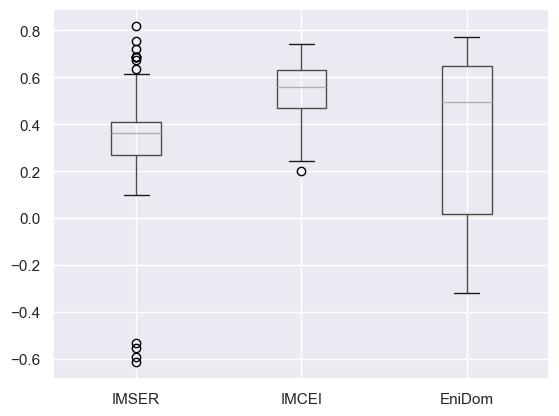

In [80]:
corr_df.boxplot()

array([[<Axes: title={'center': 'IMSER'}>,
        <Axes: title={'center': 'IMCEI'}>],
       [<Axes: title={'center': 'EniDom'}>, <Axes: >]], dtype=object)

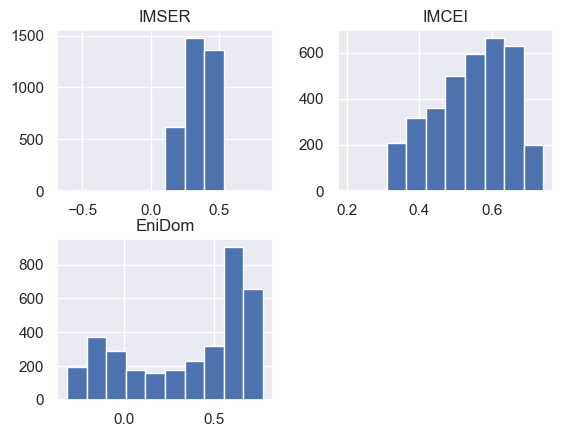

In [81]:
corr_df.hist()

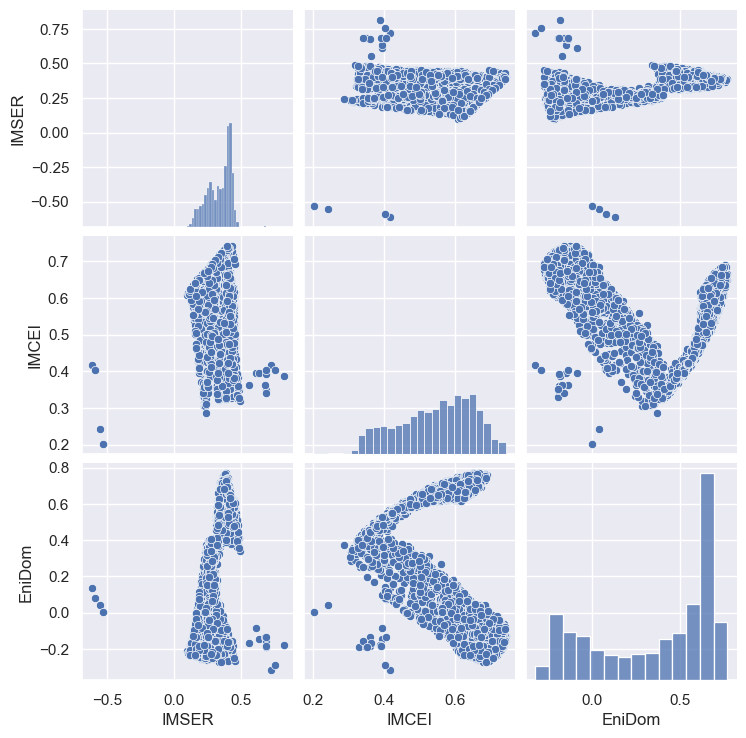

In [82]:
sns.pairplot(corr_df)

In [83]:
# Create a scatter plot
fig = go.Figure(
    data=go.Scatter(
        x=corr_df.EniDom,
        y=corr_df.IMCEI,
        mode='markers',
        hoverinfo='text',
        text=[f'Index: {i}' for i in range(len(W_sum_dist_simplex))]
        )
    )
# Add labels and title
fig.update_layout(
    xaxis_title='Correlation with EniDom',
    yaxis_title='Correlation with IMCEI',
    height=800,
    width=1000
)

In [84]:
# Create a scatter plot
fig = go.Figure(
    data=go.Scatter(
        x=corr_df.IMSER,
        y=corr_df.IMCEI,
        mode='markers',
        hoverinfo='text',
        text=[f'Index: {i}' for i in range(len(W_sum_dist_simplex))]
        )
    )
# Add labels and title
fig.update_layout(
    xaxis_title='Correlation with IMSER',
    yaxis_title='Correlation with IMCEI',
    height=800,
    width=1000
)

In [67]:
# Create a scatter plot
fig = go.Figure(
    data=go.Scatter(
        x=dist_to_cons,
        y=corr_indic,
        mode='markers',
        hoverinfo='text',
        text=[f'Index: {i}' for i in range(len(W_sum_dist_simplex))]
        )
    )
# Add labels and title
fig.update_layout(
    xaxis_title='Distance to consumption data',
    yaxis_title='Average correlation with sector indicators',
    height=800,
    width=1000
)

In [68]:
# Create a scatter plot
fig = go.Figure(
    data=go.Scatter(
        x=W_sum_dist_simplex,
        y=corr_indic,
        mode='markers',
        hoverinfo='text',
        text=[f'Index: {i}' for i in range(len(W_sum_dist_simplex))]
        )
    )
# Add labels and title
fig.update_layout(
    xaxis_title='Sum of distance to the simplex for W',
    yaxis_title='Average correlation with sector indicators',
    height=800,
    width=1000
)

## Optimal solution

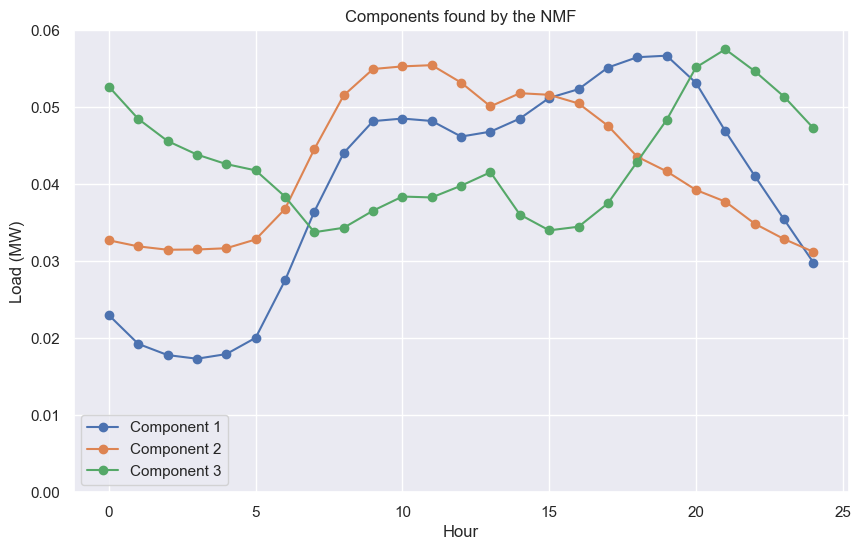

In [70]:
# Optimal run regarding minimum of distance to the consumption data
best_run = 846

H = H_results[..., best_run]
W = W_results[..., best_run]
fig, ax = plot_components(H)
ylim = ax.set_ylim((0, 0.06))

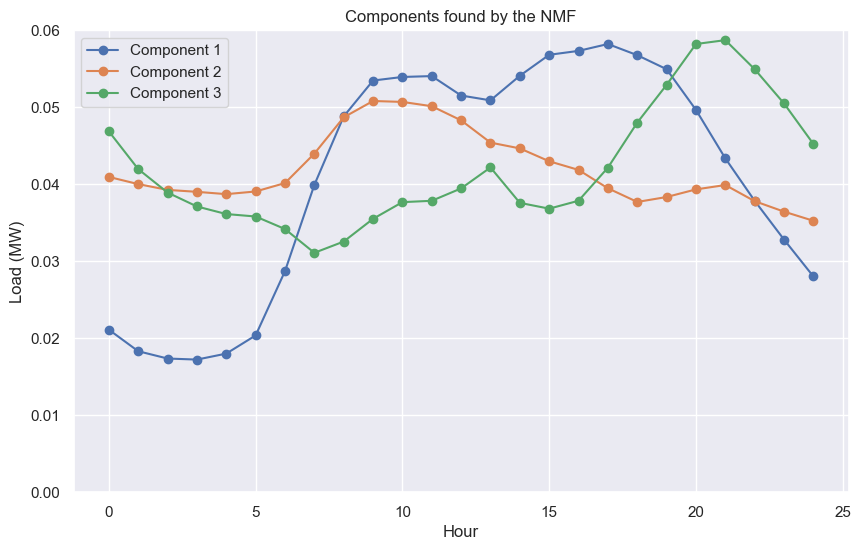

In [71]:
# Optimal run regarding minimum of distance to the simplex
best_run = 478

H = H_results[..., best_run]
W = W_results[..., best_run]
fig, ax = plot_components(H)
ylim = ax.set_ylim((0, 0.06))

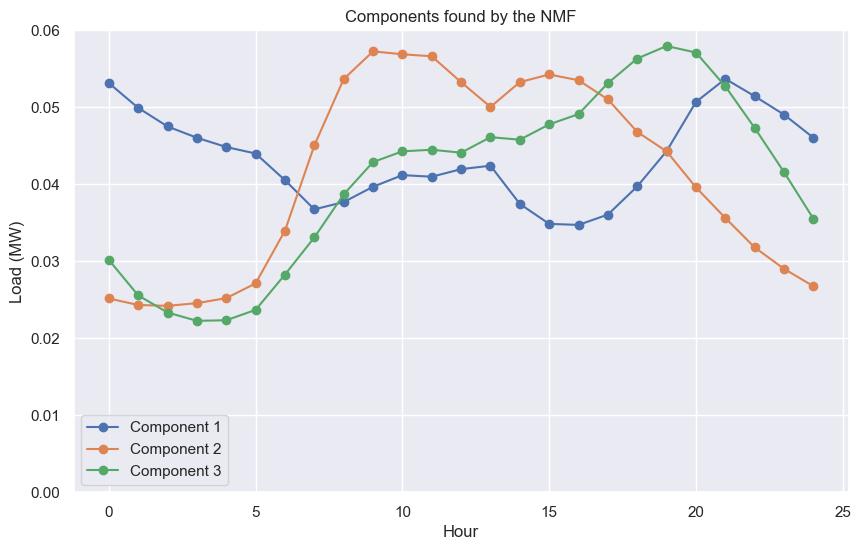

In [87]:
# Optimal run regarding the correlation with the indicators
best_run = 170

H = H_results[..., best_run]
W = W_results[..., best_run]
fig, ax = plot_components(H)
ylim = ax.set_ylim((0, 0.06))

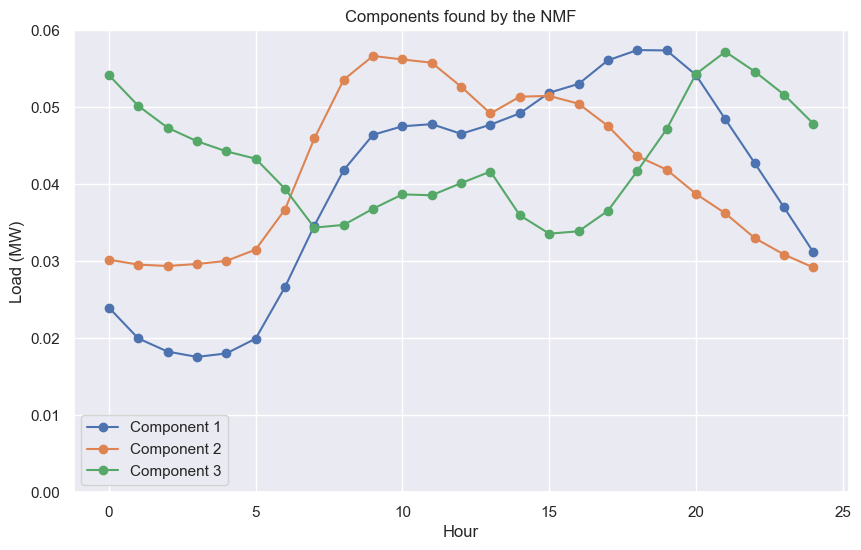

In [88]:
# Optimal run regarding the correlation with the IMCEI
best_run = 51

H = H_results[..., best_run]
W = W_results[..., best_run]
fig, ax = plot_components(H)
ylim = ax.set_ylim((0, 0.06))

# Analysis of the solution

In [305]:
# Compare the reconstructed consumption per sector with true consumption
year_cons = pd.DataFrame(cons[..., best_run], index=region_cons_df.index, columns=region_cons_df.columns)

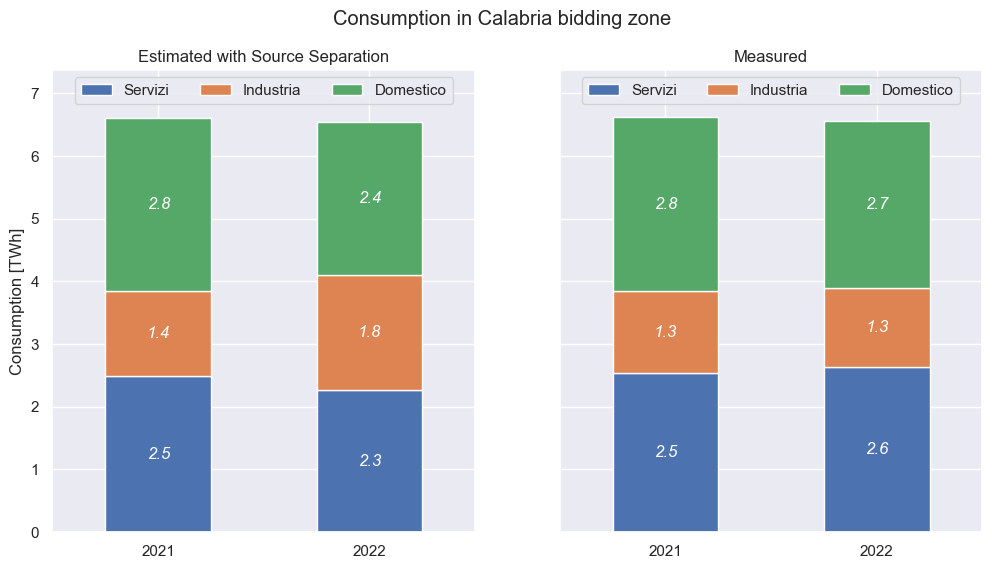

In [312]:
zone = 'Calabria'
cons_est = year_cons.loc[zone] / 1000
cons_true = region_cons_df.loc[zone] / 1000

fig, axs = plt.subplots(1, 2, figsize=(12,6), sharey=True, )
bar_est = cons_est.plot.bar(stacked=True, ax=axs[0], title='Estimated with Source Separation', ylabel='Consumption [TWh]', xlabel='')
bar_true = cons_true.plot.bar(stacked=True, ax=axs[1], title='Measured', xlabel='')

for ax in axs:
    ax.tick_params(axis='x', rotation=0)
    ax.set_ylim((0, 1.03 * ax.get_ylim()[1]))
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1), ncol=3)
    # Annotate bars with their values for the first plot
    for container in ax.containers:
        ax.bar_label(container, label_type='center', fmt='{:.1f}', color='white', fontstyle='italic')

fig.suptitle(f'Consumption in {zone} bidding zone')
plt.savefig('plots/cons_est_vs_true/{}.png'.format(zone))
plt.show()

In [160]:
W = pd.DataFrame(W, index=df.index, columns=[f"Component {k+1}" for k in range(n_components)])
W[unit_info.columns] = df[unit_info.columns]
W

,Component 1,Component 2,Component 3,region,year,month,daytype
Calabria_2021-01-01_Holiday,0.421902,1.051932e-07,0.579569,Calabria,2021,01,Holiday
Calabria_2021-01-02_Saturday,0.522838,4.725368e-02,0.430491,Calabria,2021,01,Saturday
Calabria_2021-01-03_Holiday,0.626824,6.262640e-04,0.380092,Calabria,2021,01,Holiday
Calabria_2021-01-04_Working day,0.644425,1.891011e-01,0.180313,Calabria,2021,01,Working day
Calabria_2021-01-05_Working day,0.380541,3.852541e-01,0.233172,Calabria,2021,01,Working day
...,...,...,...,...,...,...,...
South_2022-12-27_Working day,0.717729,1.038309e-01,0.189512,South,2022,12,Working day
South_2022-12-28_Working day,1.024336,8.914797e-08,0.007011,South,2022,12,Working day
South_2022-12-29_Working day,0.387689,3.335752e-01,0.277962,South,2022,12,Working day
South_2022-12-30_Working day,0.729147,3.836044e-05,0.291382,South,2022,12,Working day


In [161]:
W[(W.region == 'North')&(W.daytype == 'Working day')].sort_index().tail(20)

,Component 1,Component 2,Component 3,region,year,month,daytype
North_2022-12-01_Working day,0.302071,0.562571,0.132728,North,2022,12,Working day
North_2022-12-02_Working day,0.249705,0.625772,0.119481,North,2022,12,Working day
North_2022-12-05_Working day,0.469461,0.516659,0.020023,North,2022,12,Working day
North_2022-12-06_Working day,0.291881,0.564611,0.139274,North,2022,12,Working day
North_2022-12-07_Working day,0.266453,0.599789,0.128354,North,2022,12,Working day
North_2022-12-09_Working day,0.398906,0.479782,0.123359,North,2022,12,Working day
North_2022-12-12_Working day,0.473272,0.503025,0.030165,North,2022,12,Working day
North_2022-12-13_Working day,0.286701,0.628290,0.082482,North,2022,12,Working day
North_2022-12-14_Working day,0.262616,0.626639,0.107049,North,2022,12,Working day
North_2022-12-15_Working day,0.292781,0.623983,0.080687,North,2022,12,Working day


In [162]:
W_region = W.groupby('region')[[f"Component {k+1}" for k in range(n_components)]].sum()
W_region = W_region.div(W_region.sum(axis=1), axis=0)
W_region

,Component 1,Component 2,Component 3
region,,,
Calabria,0.394667,0.240936,0.364397
Centre.North,0.338129,0.423733,0.238138
Centre.South,0.422652,0.253983,0.323365
North,0.295929,0.467452,0.236618
Sardinia,0.205804,0.400965,0.393231
Sicily,0.344858,0.226896,0.428246
South,0.322513,0.288044,0.389443


Text(0, 0.5, '')

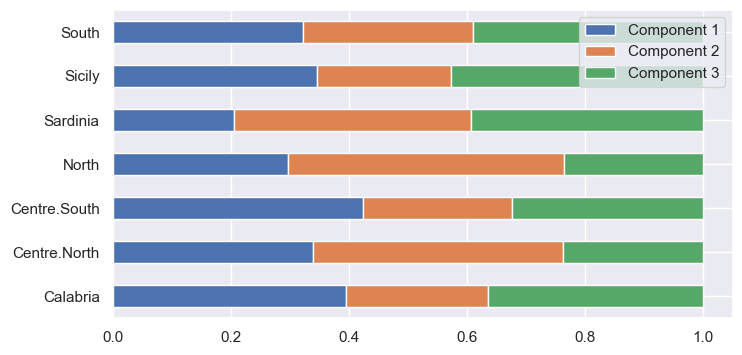

In [163]:
fig, ax = plt.subplots(1, 1, figsize=(8,4))
W_region.plot.barh(stacked=True, ax=ax)
ax.set_ylabel("")

<Axes: xlabel='component', ylabel='concentration'>

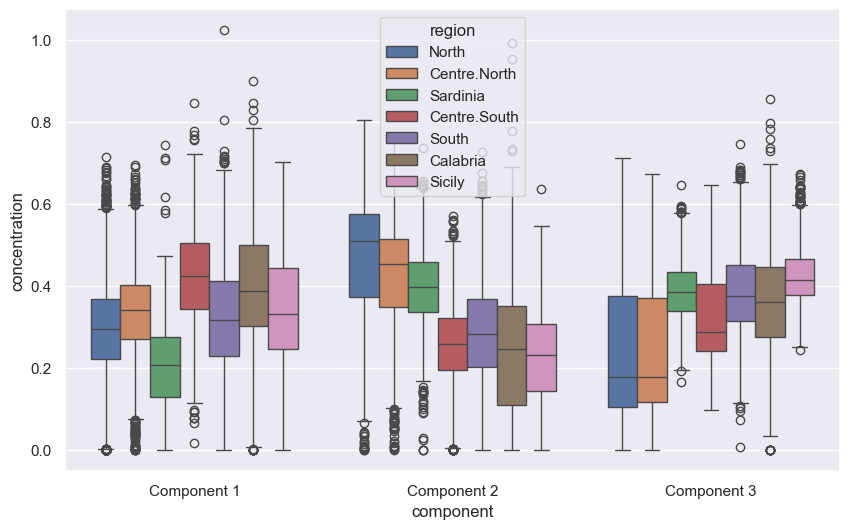

In [164]:
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=W.melt(id_vars=unit_info.columns.to_list(), var_name='component', value_name='concentration'),
    x='component',
    y='concentration',
    hue='region',
    hue_order=region_order
)

<Axes: xlabel='month', ylabel='concentration'>

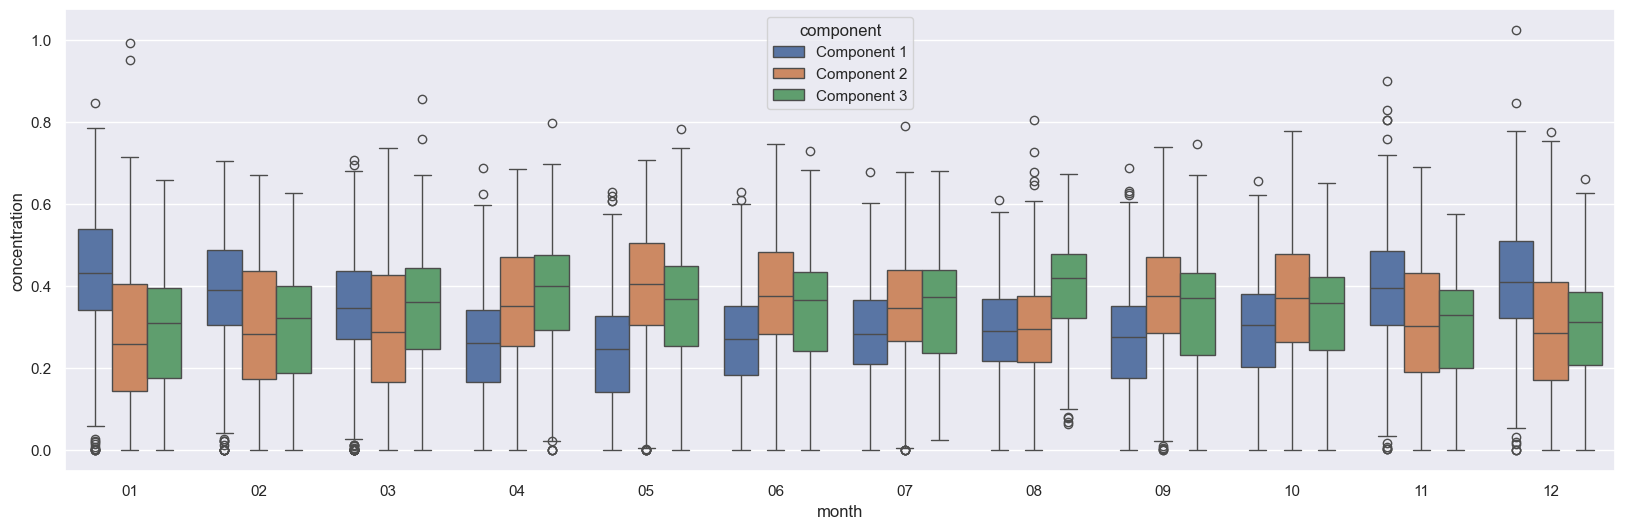

In [165]:
plt.figure(figsize=(20,6))
sns.boxplot(
    data=W.melt(id_vars=unit_info.columns.to_list(), var_name='component', value_name='concentration'),
    x='month',
    y='concentration',
    hue='component',
)

<Axes: xlabel='month', ylabel='concentration'>

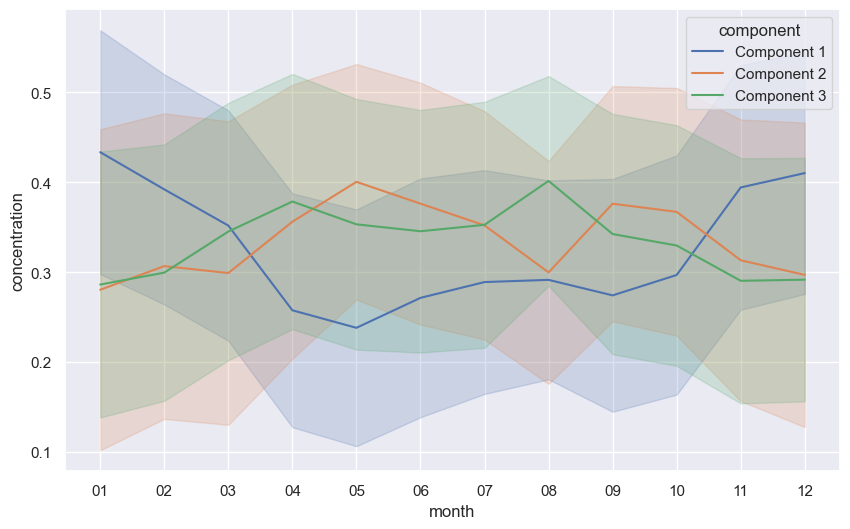

In [166]:
plt.figure(figsize=(10,6))
sns.lineplot(
    data=W.melt(id_vars=unit_info.columns.to_list(), var_name='component', value_name='concentration'),
    x='month',
    y='concentration',
    hue='component',
    errorbar='sd'
)

## Save results

In [89]:
if smoothed:
    outfile = f'data/3_output/nmf_results/WHoptimcei_{n_components}comp_smoothed_{n_runs}runs.npz'
else:
    outfile = f'data/3_output/nmf_results/WHoptimcei_{n_components}comp_{n_runs}runs.npz'
np.savez(outfile, W=W, H=H)
print("Saved results at", outfile)

Saved results at data/3_output/nmf_results/WHoptimcei_3comp_10000runs.npz


___

# TESTS